In [1]:
from ipywidgets import interact, FloatSlider
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.optimize import curve_fit



Let's concatenate a bunch of histograms with shifts in the values, simulating a different E field value for different adjusted E fields

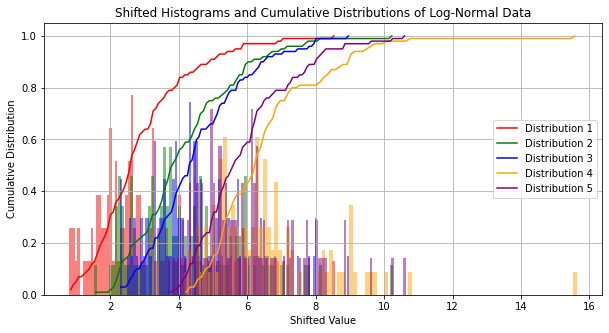

In [3]:

# Number of distributions
num_distributions = 5
sample_size = 100
mu, sigma = 1, .5  # mean and standard deviation for generating sample data
colors = ['red', 'green', 'blue', 'orange', 'purple']

# Adjusting the code to shift the data before binning and plotting the histogram

# Prepare the plot
plt.figure(figsize=(10, 5))

# Lists to hold xdata and ydata for each distribution
xdata_distributions = []
ydata_distributions = []

for i in range(num_distributions):
    # Generate sample data
    s = np.random.lognormal(mu, sigma, sample_size)

    # Shift the data by a number of bin widths
    # We estimate the bin width as the range of the data divided by the number of bins
    bin_width = (np.max(s) - np.min(s)) / 100
    shifted_s = s + i * bin_width * 10

    # Compute histogram of shifted data
    count, bins, _ = plt.hist(shifted_s, 100, density=True, align="mid", alpha=0.5, color=colors[i])

    # Calculate midpoints of bins for xdata
    xdata = (bins[:-1] + bins[1:]) / 2

    # Calculate normalized cumulative distribution for ydata
    cumulative_counts = np.cumsum(count) * np.diff(bins)
    ydata = cumulative_counts / cumulative_counts.max()
    
    xdata_distributions.append(xdata)
    ydata_distributions.append(ydata)
    
    # Plot the cumulative distribution
    plt.plot(xdata, ydata, color=colors[i], label=f'Distribution {i+1}')

all_xdata = np.hstack(xdata_distributions)  # This flattens the list of arrays into a single array
all_ydata = np.hstack(ydata_distributions)  # This flattens the list of arrays into a single array

# Customize the plot
plt.xlabel('Shifted Value')
plt.ylabel('Cumulative Distribution')
plt.title('Shifted Histograms and Cumulative Distributions of Log-Normal Data')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
def interactive_logcdf_plot_multiple_distributions(mean, std, loc):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    min_ydata_value = min([min(ydata) for ydata in ydata_distributions])

    for xdata,ydata in zip(xdata_distributions,ydata_distributions):
        # Log-Log Plot
        ax1.loglog(xdata, ydata, "o", label="Data", markersize=5)
        fitdata_log = logcdf(np.array(xdata), mean, std, loc)
        
        # Linear Plot
        ax2.plot(xdata, ydata, "o", label="Data", markersize=5)
        fitdata_linear = logcdf(np.array(xdata), mean, std, loc)

    all_fitdata_log = logcdf(np.array(all_xdata), mean, std, loc)
    ax1.scatter(all_xdata, all_fitdata_log, lw=2, label="Fitted Curve")
    ax1.set_ylim(min_ydata_value)
    ax1.set_yscale("log");
    ax1.set_xscale("log");
    ax1.set_xlabel("X")
    ax1.set_ylabel("CDF")
    ax1.set_title("Log-Log Plot")
    ax1.legend()

    all_fitdata_linear = logcdf(np.array(xdata), mean, std, loc)

    ax2.plot(all_xdata, all_fitdata_linear, lw=2, label="Fitted Curve")

    ax2.set_xlabel("X")
    ax2.set_ylabel("CDF")
    ax2.set_title("Linear Plot")
    ax2.legend()

    plt.tight_layout()
    plt.show()


log fit failed, using guess.
Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
fitted_params
[0.8, 0.6, 2.3]


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


<function __main__.interactive_logcdf_plot_multiple_distributions(mean, std, loc)>

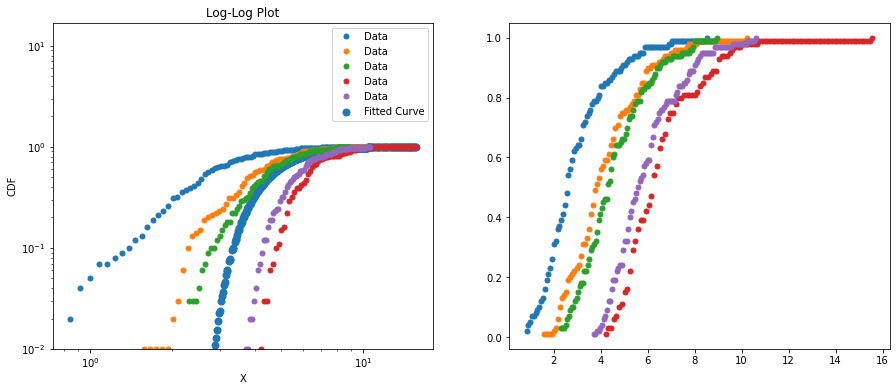

In [14]:
from scipy.optimize import curve_fit
from scipy.stats import lognorm
import numpy as np
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt

# Define the logcdf function with a check for overflow
def logcdf(x, mu, sigma, loc):
    scale = np.exp(mu)
    # Check for overflow
    if np.isinf(scale):
        print(f"Overflow with mu = {mu}")
        scale = np.finfo(float).max
    return lognorm.cdf(x, s=sigma, scale=scale, loc=loc)

# Modify the fitLognormalCDF function to accept the concatenated data
def fitLognormalCDF(xdata, ydata, guessmu, guesssigma, guessloc):
    try:
        params, covar = curve_fit(
            logcdf, xdata, ydata, p0=[guessmu, guesssigma, 0], maxfev=10000
        )
    except Exception as e:
        print("log fit failed, using guess.")
        print(e)
        return [guessmu, guesssigma, guessloc]
    return params

# Fit the log-normal distribution to the combined ydata
guessmu = .80  # Initial guess for mu
guesssigma = 0.6  # Initial guess for sigma
guessloc = 2.3  # Initial guess for loc

# Perform the fit on the combined dataset
fitted_params = fitLognormalCDF(all_xdata, all_ydata, guessmu, guesssigma, guessloc)
print("fitted_params")
print(fitted_params)
# Set the sliders to the fitted parameters
mean_slider = FloatSlider(value=fitted_params[0], min=.2, max=1, step=0.1, description='Mean:')
std_slider = FloatSlider(value=fitted_params[1], min=0.1, max=.9, step=0.01, description='Std Dev:')
loc_slider = FloatSlider(value=fitted_params[2], min=-10, max=10, step=0.1, description='Loc:')

# Define the interactive plotting function as before

# Use interact to create interactive plots with fitted parameters
interact(interactive_logcdf_plot_multiple_distributions, mean=mean_slider, std=std_slider, loc=loc_slider)
